# Face Recognition using Eigenfaces and SVMs

In this code, we will implement a face recognition system using eigenfaces and support vector machines (SVMs). The code will perform the following steps:

1. Data Preprocessing: We will resize the images, convert them to grayscale, and normalize the pixel values.
2. Eigenface Extraction: We will use Principal Component Analysis (PCA) to extract eigenfaces from the preprocessed images.
3. Training the SVM: We will train an SVM classifier using the extracted eigenfaces.
4. Testing and Evaluation: We will evaluate the performance of the trained SVM on a test set and generate a classification report and confusion matrix.
5. Qualitative Evaluation: We will visualize the predicted labels and the most significant eigenfaces.

Let's get started!


### matplotlib inline
When this code is executed:

`%matplotlib inline$`

it sets the backend of matplotlib to render the plots as static images and directly display them within the notebook cell. This allows us to see the plots immediately after executing the code cell without the need for additional commands to show or save the plots.

In [3]:
%matplotlib inline

### Importing Required Libraries

The following libraries are imported for various functionalities used in the code:


In [9]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

### Dataset
Original Dataset consists of images of different characters of Marvel movies, which are organized into folders, with each folder representing a different character.

### Preparing the Dataset
The dataset is prepared by reading the images and their corresponding labels. The dataset path is specified using the dataset_path variable. The images are resized, converted to grayscale, and flattened to 1D vectors. The preprocessed images and labels are stored in the X and y variables, respectively.

In [ ]:
import os
import cv2
import numpy as np

# Specify the path to your dataset directory
dataset_path = 'archive'

# Read the images and labels from the dataset directory
X = []
y = []
target_names = os.listdir(dataset_path)
for class_name in target_names:
    class_dir = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Preprocess the image as needed (e.g., resizing, normalizing pixel values)
        image = cv2.resize(image, (100, 100))  # Update the size as per your requirements
        image = image.flatten()  # Convert the image to a 1D vector
        X.append(image)
        y.append(class_name)

X = np.array(X)
y = np.array(y)

n_samples, n_features = X.shape
n_classes = len(target_names)

# Print Details about the dataset
print("Number of Data Samples: %d" % n_samples)
print("Size of a Data Sample: %d" % n_features)
print("Number of Class Labels: %d" % n_classes)


## Data Split and Normalization

Next, we split the dataset into training and test sets using the `train_test_split` function from `sklearn.model_selection`. We set aside 20% of the data for testing. To ensure that the input features have a consistent scale, we apply normalization using the `StandardScaler` from `sklearn.preprocessing`. The training set is fit-transformed using the scaler, while the test set is transformed using the fitted scaler.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training set
X_train = scaler.fit_transform(X_train)

# Transform the test set using the fitted scaler
X_test = scaler.transform(X_test)

## Dimensionality Reduction with PCA

Since images can have high-dimensional feature spaces, we apply dimensionality reduction using Principal Component Analysis (PCA). This unsupervised technique helps extract the most informative features from the dataset. We compute the eigenfaces, which are the top principal components, using the `PCA` class from `sklearn.decomposition`. We specify the desired number of eigenfaces (e.g., 100) and fit the PCA model to the training set. We then transform both the training and test sets to obtain the corresponding principal components.


In [10]:
n_samples, n_features = X_train.shape
h = int(np.sqrt(n_features))
w = int(n_features / h)
n_components = 100  # Define the desired number of eigenfaces

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 100 eigenfaces from 468 faces
done in 1.640s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.112s


## SVM Classification Model

For character recognition, we use a Support Vector Machine (SVM) classification model. We fit the SVM to the training set using the `SVC` class from `sklearn.svm`. To find the best hyperparameters, we perform a randomized search using `RandomizedSearchCV` from `sklearn.model_selection`. The hyperparameters to be tuned include the regularization parameter `C` and the kernel parameter `gamma`.


In [11]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 1.589s
Best estimator found by grid search:
SVC(C=73560.54203010877, class_weight='balanced', gamma=0.009113549684661014)


### Quantitative Evaluation of the Model Quality on the Test Set
This section evaluates the quality of the trained model on the test set. It provides quantitative metrics to assess the performance of the Support Vector Machine (SVM) classifier. The evaluation includes generating a classification report that shows metrics such as precision, recall, F1-score, and support for each class. Additionally, a confusion matrix is generated to visualize the classification results.


Predicting people's names on the test set
done in 0.029s
                                       precision    recall  f1-score   support

          bruce_banner (Mark Ruffalo)       0.83      0.83      0.83        24
         clint_barton (Jeremy Renner)       0.87      0.87      0.87        23
Natasha_Romanoff (Scarlett Johansson)       0.76      0.68      0.72        19
               thor (Chris Hemsworth)       0.76      0.76      0.76        21
       tony_stark (Robert Downey Jr.)       0.69      0.79      0.73        14
           steve_rogers (Chris Evans)       0.65      0.65      0.65        17

                             accuracy                           0.77       118
                            macro avg       0.76      0.76      0.76       118
                         weighted avg       0.77      0.77      0.77       118



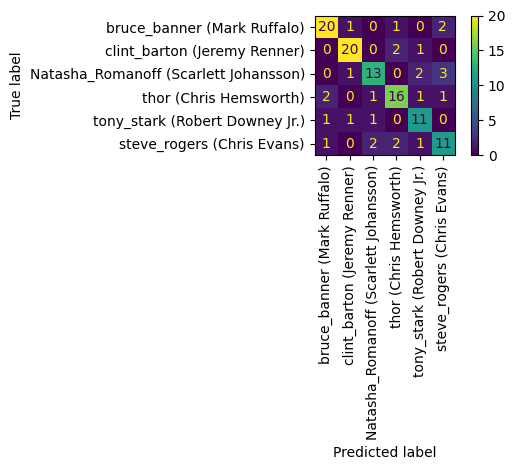

In [12]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

### Qualitative Evaluation of the Predictions using Matplotlib
This section provides a qualitative evaluation of the trained model's predictions. It uses Matplotlib to visualize the predicted labels and the most significant eigenfaces. The predicted labels are displayed alongside the corresponding test images, allowing for a visual assessment of the model's performance.


In [13]:
def plot_gallery(images, titles, h, w, n_row=12, n_col=1):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot the result of the prediction on a portion of the test set



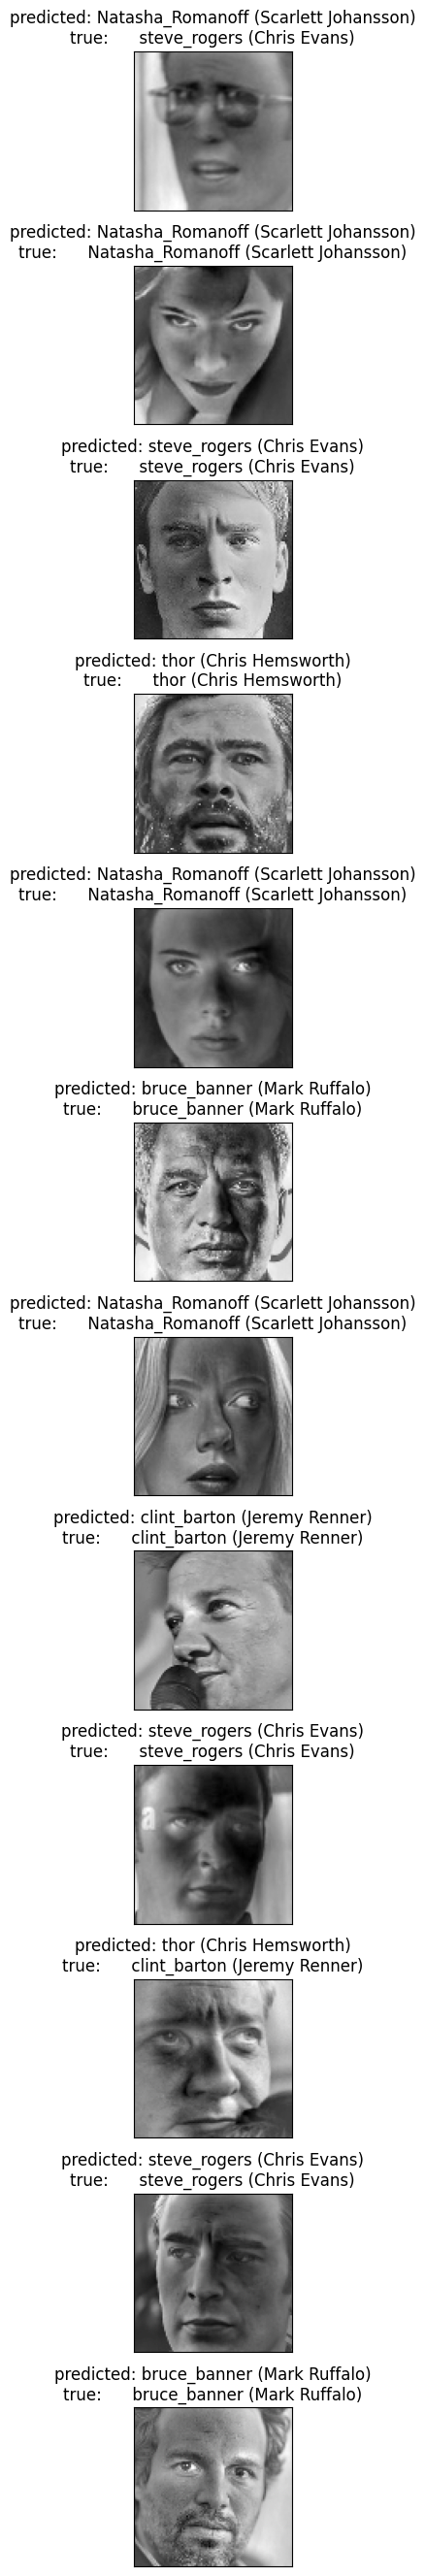

In [14]:
def title(y_pred, y_test, target_names, i):
    pred_name = y_pred[i]
    true_name = y_test[i]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

# Generate prediction titles
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(len(y_pred))
]

# Plot the gallery
plot_gallery(X_test, prediction_titles, h, w)


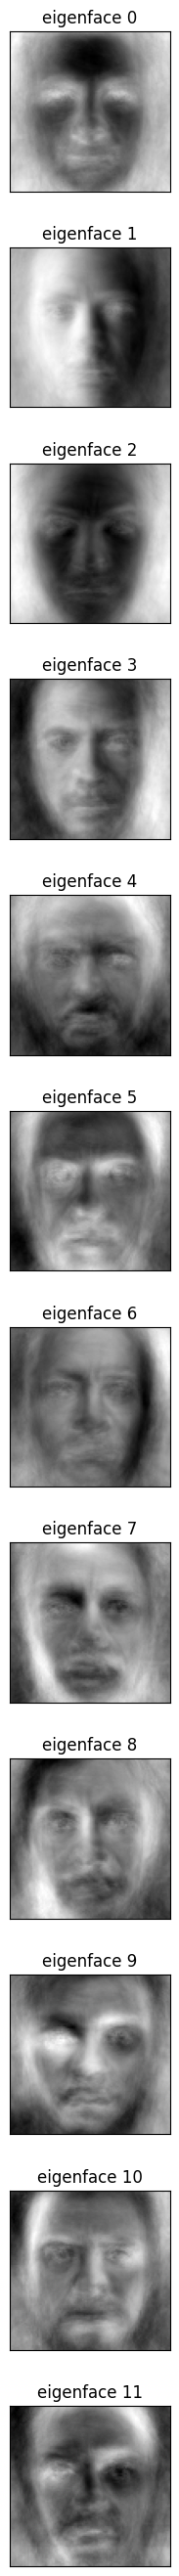

In [15]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Testing by Predicting an Image from File Path
This section demonstrates how to use the trained model to predict the label of an individual image. It serves the purpose of illustrating the application of the face recognition system on new, unseen images. By providing the file path of an image, the system preprocesses the image, applies PCA transformation, and predicts the label using the trained SVM classifier. The predicted label represents the recognized character in the image.


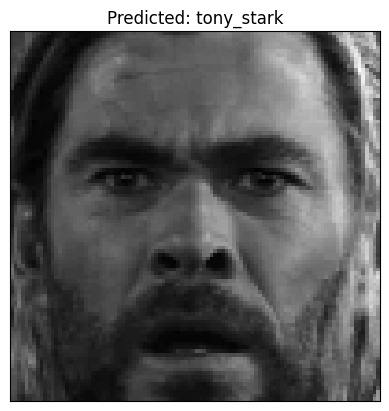

In [30]:
import cv2
import numpy as np

# Load the image from the file path
image_path = "./thor18.png"  # Replace with the actual file path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image as needed (e.g., resizing, normalizing pixel values)
image = cv2.resize(image, (100, 100))  # Update the size as per your requirements
image = image.flatten()  # Convert the image to a 1D vector

# Perform PCA transformation on the selected image
selected_image_pca = pca.transform([image])

# Predict the label of the selected image
predicted_label = clf.predict(selected_image_pca)

# Extract the character name from the predicted label
predicted_name = predicted_label[0].split(" ")[0]

# Display the selected image and its predicted label
plt.figure()
plt.imshow(image.reshape((100, 100)), cmap=plt.cm.gray)
plt.title(f"Predicted: {predicted_name}", size=12)
plt.xticks(())
plt.yticks(())
plt.show()
